<a href="https://colab.research.google.com/github/stavco9/moe-llm-presentation/blob/main/presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixture of experts Language Model presentation

## Noam Delbari & Stav Cohen

## 1 Background:

### 1.1 Transformers

A **Transformer** is an *encoder–decoder* sequence‑to‑sequence model that performs all its
computation with stacked **self‑attention** layers and small position‑wise feed‑forward networks (FFNs),
with **no recurrence or convolution**. This design lets every token interact with every other token in
one parallelizable matrix operation, unlocking massive throughput on modern accelerators.

###  Standard Transformer

| Sub-layer | Inputs | Outputs | Purpose |
|-----------|--------|---------|---------|
| **Self-Attention** | A sequence of token embeddings $X\!\in\!\mathbb{R}^{L\times d}$ | A new sequence $Z\!\in\!\mathbb{R}^{L\times d}$ | Mix information across all positions using *scaled dot-product attention*. |
| **Add + LayerNorm** | Residual input + sub-layer output | Normalised sum | Stabilise training and preserve gradients (residual path). |
| **Feed-Forward Network (FFN)** | Each token independently | Transformed tokens | Non-linear feature expansion: two linear maps with GELU/ReLU in between. |
| **Positional Encoding / Bias** | Token index | Vector added to embeddings or into attention logits | Inject order information, because plain attention is permutation-invariant. |

> **Encoder stack** repeats: (Self-Attn → FFN) × N  
> **Decoder stack** repeats: (Causal Self-Attn → Cross-Attn → FFN) × N


<figure>
  <img src="switch_plots/transformer.png" width="300"/>
  <figcaption><b>Figure 1</b> – Transformer architecture.</figcaption>
</figure>


#### 1. Embedding Stage

Raw word-pieces are mapped to $d$-dimensional vectors and receive a positional signal (either sinusoidal values or a learned bias).

**Result:** “Naked” token embeddings that know their position but nothing yet about their neighbours.

#### 2. Encoder Conveyor (× N layers)

For *N* identical encoder layers the vectors ride through the same three-step processing loop:

1. **Self-Attention**  
   Every token points a spotlight at all other tokens, gathers a weighted sum of their features, and replaces its own vector with that mixture.  
   Instantly injects **global context**—long-range dependencies can be captured in a single hop.

2. **Residual & LayerNorm**  
   Add the mixer’s output back to the original vector (so nothing is forgotten), then apply LayerNorm (so activations stay in a healthy range).

3. **Feed-Forward Refiner**  
   Apply a two-layer MLP with GELU/ReLU per token—no cross-token interaction.  
   Acts as a non-linear feature transformer, increasing capacity.

After a second residual+norm, the token moves to the next layer carrying both its original identity and all the context it just absorbed.

> **Outcome:** After *N* laps, each encoder vector is a rich, position-aware summary of the entire source sentence. The tensor shape ($L \times d$) never changes—only the **information content** inside each vector grows.

#### 3. Decoder Conveyor (× N layers)

The decoder also loops *N* times, but each layer adds a “side-road”:

1. **Causal Self-Attention**  
   Tokens attend only to positions $\le t$ (auto-regressive).  
   **Result:** each position knows everything generated so far, but not the future.

2. **Residual & LayerNorm**

3. **Cross-Attention Bridge**  
   *Queries* = decoder state; *Keys/Values* = frozen encoder outputs.  
   Aligns the partially generated target with relevant source content.

4. **Residual & LayerNorm**

5. **Feed-Forward Refiner**  
   Same per-token MLP as in the encoder.

> **Loop:** Tokens accrue context from both their left-hand history and the full source sentence over *N* layers.

#### 4. Output Projection

After the final decoder layer each vector passes through a shared linear map + softmax to produce a probability distribution over the next vocabulary token.

- **Training:** use teacher forcing (ground-truth next token).  
- **Inference:** sample or pick the top token and feed it back as the next input, advancing the conveyor.

#### 5. The Big Picture

- **Encoder:** builds a *bidirectional* representation of the source (Self-Attn + FFN).  
- **Decoder:** generates the target *left-to-right*, consulting both its own history (causal Self-Attn) and the encoder (Cross-Attn).  
- **Residual highways** keep gradients flowing; **LayerNorm** keeps scales stable; **Feed-Forward sub-nets** inject non-linearity.  
- The tensor shape ($L \times d$) stays constant; **contextual and abstract information** accumulates at each hop.

> In **Switch Transformers** the only change is that the dense FFN sub-nets are replaced by a **Switch-FFN** (Mixture-of-Experts). The underlying conveyor-belt flow—attention mixers, residual paths, cross-attention bridge—remains exactly the classic Transformer structure.


####   Why does it work  

* **Parallelism** – all tokens processed simultaneously (unlike RNNs).  
* **Long-range dependencies** – any token can attend to any other in one hop.  
* **Expressiveness** – stacking layers lets the model build hierarchical features.  
* **Speed** – matrix multiplications map well to GPUs/TPUs.


---

### 1.2 Mixture-of-Experts (MoE)

1. ***What is an expert*** ?
A small and specialized model which got trained for a particular area. It can be a neural network, decision tree, or other algorithm. In our case experts are small neural networks

2. ***A Mixture of Experts (MoE) model***
A model that combines the predictions of multiple experts to solve complex problems.
- Each expert is trained on a specific domain or task, and a "gating network" or "router" selects the most appropriate experts for a given input.

3. ***"gating network" / "router"***
A component (a tiny linear layer) in the large model that determines which experts should be activated for a particular input. It's also trained along with the experts

4. ***What do we achieve from that***
The main benefit of the MoE architecture is that it enables large-scale models, even those comprising many billions of parameters, to reduce computation costs during pre-training and achieve faster performance during evaluation time.

5. ***How does it work ?***
It reaches it's major benefit by selectively activating only the specific experts needed for a given task, rather than activating the entire neural network for every task.

6. ***An illustration of a standard MoE network***
<img src="https://github.com/stavco9/moe-llm-presentation/blob/main/Peer_Layer.png?raw=1" alt="Peer_Layer" width="700" height="700">

## 2 Switch transformer

## 2.1 Introduction:

Large language models (LLMs) have achieved striking gains by growing from millions
to billions of parameters—yet *dense* scaling makes **every** parameter participate
in **every** forward-pass.  
Compute (FLOPs), memory traffic, and wall-time therefore grow linearly with model
size, and the trillion-parameter frontier strains even the largest clusters.

**Mixture-of-Experts (MoE)** layers offer a different path: *conditional
computation*.  
A lightweight *gating network* selects **one** or **few** specialized “experts”
(MLPs) per token, so only a *subset* of parameters is active each step.
Switch Transformers (Fedus *et&nbsp;al.*, 2022) refine this idea to make it practical
at unprecedented scale.

### Why previous MoE attempts struggled  

| Bottleneck in earlier MoE work | What it means | Switch Transformer’s remedy |
| :-- | :-- | :-- |
| **Unstable top-k routing** (k > 1) | When every token is split across *k* experts (k = 2,4…), the soft mixture may starve some experts of gradient signal → divergence in very deep models. | **k = 1 “switch” routing**: each token is sent to exactly one expert chosen by `argmax` over gate logits. This keeps gradients intact and halves the routing tensor size. |
| **Cross-device communication** | Prior systems sliced *one* expert across many GPUs/TPUs → every step required an All-to-All of hidden states. | **Expert-parallel layout**: each device *owns* one whole expert. Tokens are grouped by destination expert, transferred *once*, processed locally, then regrouped—minimising traffic. |
| **Token imbalance (hot-spot experts)** | Popular tokens (e.g., punctuation) can overload a few experts, leaving others idle and blowing up memory. | **Auxiliary load-balancing loss**: penalises correlation between (i) fraction of tokens routed to expert *i* and (ii) gate probability mass on expert *i*.  <br>$$ L_{\text{aux}} = \alpha\,N \sum_{i=1}^{N} f_i\,P_i \quad\text{(Eq.\;4)} $$ |

*Definitions*  
* **Expert** – an independent feed-forward sub-network (here, a position-wise MLP).  
* **Gating network** – a tiny linear layer that produces *N* logits per token.  
* **Routing** – assigning tokens to experts based on gate probabilities.  
* **FLOPs / token** – floating-point operations needed for one token’s forward-pass.

---

### Research Questions

This paper explicitly addresses several critical research questions:

1. **Efficiency vs. Model Capacity:**  
   *Does increasing model size through sparse routing (more experts) consistently improve language model performance (perplexity) without proportional computational cost?*

2. **Training Stability:**  
   *Can models at trillion-parameter scale be stably trained using lower-precision arithmetic (like bfloat16)?*

3. **Downstream Generalization:**  
   *Do improvements obtained during language modeling pre-training generalize to downstream tasks (e.g., QA, summarization)?*

4. **Model Compression and Deployment:**  
   *Is it feasible to distill sparse models into smaller, dense models while preserving performance improvements?*

---


## 2.2 High-level Structure  

A Switch Transformer layer is identical to a standard Transformer block **except** that the
dense Feed-Forward Network (FFN) is replaced by a **Switch-FFN** (sparse Mixture-of-Experts).  
Figure 2 from the paper illustrates the encoder block with two example tokens (${x_1,x_2}$).  
Only the shaded *Switch-FFN* (light-blue) differs from a dense model.  :contentReference[oaicite:1]{index=1}

<figure>
  <img src="switch_plots/figure2_switch_arch.png" width="600"/>
  <figcaption><b>Figure 2</b> – Switch-FFN inside the Transformer block (Fedus et al., 2022).</figcaption>
</figure>



| Component | Role |
| :-- | :-- |
| **Self-Attention** | Context mixing (unchanged). |
| **Router** | Lightweight linear layer that decides **which expert** handles each token. |
| **N Experts** | Independent MLPs (usually GELU) with identical shapes but **distinct parameters**. |
| **Load-Balancing Loss** | Keeps traffic roughly uniform across experts. |


## 2.3 Routing & Gating Mechanism

### **Overview**

The critical innovation of **Switch Transformers** lies in the routing mechanism—specifically, how each token dynamically selects exactly one expert out of several available experts (MLPs). This approach dramatically reduces computational overhead while allowing massive scaling in model size.


### **Router Inputs**

Each Transformer layer typically consists of Self-Attention followed by Layer Normalization (LayerNorm). In a standard Transformer, the resulting hidden state would directly enter a dense Feed-Forward Network (FFN).

In **Switch Transformers**, the router receives the **same hidden state**—specifically, the output embedding after the Self-Attention block and LayerNorm step: $\mathbf{x} \in \mathbb{R}^{d_{\text{model}}}$

Here, $ d_{\text{model}} $ denotes the embedding dimensionality.

The router input is thus fully contextualized at the token level but does not depend directly on other tokens' routing decisions, which allows independent per-token routing computations.

### **Routing Computation**

The routing mechanism is computed as follows:

**Step-by-Step:**

1. **Router Projection (Compute logits)**

The router projects the token representation into a space of dimension equal to the number of experts \( N \):

$$
h_i(\mathbf{x}) = \mathbf{w}_i^\top\mathbf{x} + b_i,\quad \forall i\in\{1,\dots,N\}
$$

Each expert has its own set of weights $ \mathbf{w}_i \in \mathbb{R}^{d_{\text{model}}} $ and biases $ b_i $.

2. **Softmax Normalization**

The logits are normalized via softmax to form a probability distribution over the experts:

$$
p_i(\mathbf{x}) = \frac{\exp(h_i(\mathbf{x}))}{\sum_{j=1}^{N}\exp(h_j(\mathbf{x}))}
$$

3. **Jitter Addition (Exploration Noise)**

A small uniform noise ("jitter") is added during training to encourage exploration of different routing decisions and prevent early convergence (collapse):

$$
\tilde{p}_i(\mathbf{x}) = p_i(\mathbf{x}) + \epsilon,\quad \epsilon\sim\mathcal{U}(0,10^{-2})
$$

4. **Top-1 Selection**

The Switch Transformer chooses exactly **one expert** per token (top-1 selection):

$$
i^{\star} = \arg\max_{i}\tilde{p}_i(\mathbf{x})
$$

5. **Expert Processing**

The selected expert (MLP) processes the token embedding:

$$
\mathbf{e} = E_{i^{\star}}(\mathbf{x})
$$

Each expert $E_i$ is a two-layer MLP with GELU activation, independent parameters, and identical structure across experts.

6. **Gate-weighted Output**

The output from the expert is multiplied by the original gate probability (without jitter) to keep the routing decision differentiable and allow gradient flow through the router:

$$
\mathbf{y} = p_{i^{\star}}(\mathbf{x})\,\mathbf{e}
$$

This operation, known as a "straight-through estimator," ensures smooth training despite discrete expert selection.


### **Capacity and Hard Limit**

<figure>
  <img src="switch_plots/figure3_capacity_dynamics.png" width="650"/>
  <figcaption><b>Figure 3 — Token-routing dynamics under two capacity factors.</b></figcaption>
</figure>

**What the diagram shows**

*Left panel (capacity 1.0)*  
* 12 tokens must be routed across three experts (rows).  
* Each expert’s capacity is exactly the ideal load \(B/N = 4\) tokens.  
* Because many tokens happen to share the same favourite expert, that expert
  overflows — the dotted red boxes show the **dropped** tokens that will bypass
  this layer.

*Right panel (capacity 1.5)*  
* The capacity per expert is now \(4 \times 1.5 = 6\) tokens, giving 50 % slack.  
* All 12 tokens fit; no red overflow boxes, but a few **empty white slots** indicate
  wasted compute/communication.

**Take-away** A small slack margin (the paper standardises on 1.25) almost
eliminates overflows yet keeps extra FLOPs and bandwidth modest.  Capacity is
therefore the runtime *circuit-breaker* that guarantees fixed memory and latency
even when the router’s token-to-expert distribution is skewed.

**Why does capacity matter?**

Routing decisions can lead to unbalanced token assignments, with some experts overloaded while others remain underutilized. Without mitigation, overloaded experts would cause out-of-memory errors, degraded performance, and unpredictable latency.

Switch Transformer addresses this via a **hard capacity limit** on each expert:

$$
\text{capacity per expert} = \left\lceil \frac{B}{N} \times \text{capacity\_factor} \right\rceil
$$

- $ B $: Total number of tokens in the micro-batch
- $ N $: Number of experts
- $\text{capacity\_factor}$: Typically set to $1.25$

### **Load-Balancing Losses**

Early attempts at Mixture-of-Experts models encountered a critical problem known as **expert collapse**, where a small number of experts dominated token assignments, starving others of training signal. Switch Transformers introduced two auxiliary losses to prevent collapse and encourage balanced expert usage:

#### 1. **Auxiliary Load-Balancing Loss**

$$
L_{\text{aux}} = \alpha N \sum_{i=1}^{N} f_i P_i,\quad
f_i = \frac{\text{tokens routed to expert } i}{\text{batch size}},\quad
P_i = \text{average gate probability for expert } i
$$

**Intuition:**  
- Encourages even token distribution by penalizing high correlation between an expert’s frequency of selection and router confidence.
- If an expert is frequently chosen and with high confidence, the loss increases, nudging the model to utilize other experts more evenly.

#### 2. **Z-Loss (Logit Regularization)**

$$
L_z = \beta \sum_{\text{tokens}}\sum_{i}(h_i - \text{stop\_grad}(h_i))^2
$$

**Intuition:**  
- Encourages router logits $h_i$ to remain small in magnitude, preventing overly confident selections (extremely large or small logits can destabilize softmax distributions).
- Maintains stable gradient flow and well-conditioned router softmax.

**Effectiveness:**
- These combined losses improve expert utilization entropy, reduce gradient variance across experts, accelerate training convergence, and improve overall training stability.
- Compared to earlier MoE methods, these light-weight auxiliary losses significantly improve model scalability and robustness with minimal computational overhead.


## 2.4  “Towards Trillion-Parameter Models”  

**Goal**  
Demonstrate that the Switch-Transformer recipe can be pushed two orders of magnitude beyond the 26 B-param “Large” model, into the *hundreds-of-billions* and *trillion* range, **without exploding compute per token** and while remaining trainable on today’s hardware.

####  Parallelism Blueprint  

To fit and feed models that big, the authors layer three kinds of parallelism:

* **Data parallelism** – duplicates the entire model across many devices; cheap but multiplies the activation-update bandwidth.
* **Model (tensor) parallelism** – splits individual weight matrices across devices; adds intra-layer communication every step.
* **Expert (Mixture) parallelism** – puts different experts on different devices and ships only the tokens that need them; communication is an All-to-All once per MoE layer.

The **sweet spot** is a *hybrid*:  
> *Data ∥ Model ∥ Expert* — balance memory, FLOPs, and bandwidth so no single axis bottlenecks first.

####  Concrete Mega-Models

| Model | Params | Experts / layer | Devices & layout | FLOPs / sequence |
|-------|--------|-----------------|------------------|------------------|
| **Switch-XXL** | 395 B | 64 | 2048 TPU v3 cores, D×M×E = 8×8×4 | 6.3 T |
| **Switch-C**   | 1.6 T | 128 | 2048 TPU v3 cores, D×M×E = 8×8×32 | 0.89 T |

*Switch-C* spends **~7× fewer FLOPs per sequence** than T5-XXL while owning ~150× more parameters, because only one expert runs per token.

####  Training Behaviour

* **395 B & 1.6 T models converge stably** with bf16 + router-fp32.  
* At 250 k steps on C4 (≈ 20 B tokens) both sparse giants already beat T5-XXL’s perplexity; the gap widens by 500 k steps.  
* **Switch-C reaches target quality 4 × faster** than T5-XXL for the same compute budget.

Occasional instability (loss spikes) appears in the higher-FLOP Switch-XXL, highlighting the importance of the lower-FLOP design of Switch-C.

####  Early Down-Stream Signals  

A partially-trained Switch-XXL, fine-tuned on knowledge-heavy tasks, outperforms T5-XXL on closed-book QS benchmarks (Natural Questions, TriviaQA, Web Questions).  
Reasoning-heavy sets (SQuAD2, SuperGLUE) are on par—suggesting more training or tailored hyper-params may be needed there.

####  Key Lessons  

1. **Mixture-of-Experts + hybrid parallelism unlocks trillion-parameter scale** without proportionally increasing per-token compute.  
2. **Hardware efficiency matters more than raw parameter count**: Switch-C (1.6 T, lower FLOPs) trains faster and more stably than a naïvely larger-FLOP variant.  
3. **Upstream gains still translate**—especially on knowledge-centric tasks—confirming that sparse giants learn useful representations, not just memorisation.  

These results provide the first concrete roadmap to practical *trillion-parameter* language models on contemporary TPU/GPU clusters.


## 2.5 Experiments & Results
### Baseline Models Used for Comparison  

The authors selected **four families** of comparison models, each serving a distinct purpose.

####   Dense T5 Series – 
**T5** stands for **“Text-to-Text Transfer Transformer.”**  
Released by Google in late 2019, it introduced a simple yet powerful idea: *cast every NLP task—translation, summarisation, QA, sentiment, …—as feeding one piece of text in and predicting another piece of text out.*  
This unification plus large-scale span-corruption pre-training on the **C4** web corpus produced a strong encoder–decoder baseline.

**Why the authors picked T5:**

1. **Like-for-like objective and codebase** – eliminates spurious gains from task formulation or optimiser tweaks.  
2. **Widely reported benchmarks** – GLUE / SuperGLUE / SQuAD scores for T5 are standard yard-sticks, so improvements are easy to contextualise.  
3. **Scales up smoothly** – letting the paper test whether sparse scaling beats a dense model simply made *bigger* (e.g., T5-Large or T5-XXL).

Thus, throughout the experiments T5 provides a **clean, well-understood dense baseline** against which the efficiency and quality of the Switch (sparse) approach can be judged.


| Model | Params | FLOPs / token | Why chosen |
|-------|--------|--------------|-----------|
| **T5-Base** | 223 M | 1 × (reference) | Same size class as 2-expert Switch; establishes a dense baseline that already fits on a single TPU/GPU. |
| **T5-Large** | 739 M | 3.5 × Switch-Base | Represents a “scale-up dense” strategy within the same architecture and codebase. |
| **T5-XXL** | 11 B | 6.3 T per seq | State-of-the-art dense model at publication time; tests whether sparse can outpace *very* large dense models under the same cluster budget. |

*Rationale* – All T5 variants share the *exact* training objective, tokenizer, and optimizer code. That isolates the effect of **conditional vs dense compute**.

####   MoE Transformer (Top-2 Routing) – 

| Variant | Experts | Routing | Why chosen |
|---------|---------|---------|-----------|
| **MoE-Transformer (Shazeer et al.)** | 128 | top-2 | Prevailing MoE design before Switch; higher FLOPs because two experts fire per token. |

*Rationale* – Validates whether **single-expert** routing is genuinely more efficient/stable than the established top-k approach.

#### Why these baselines are fair  

* **Same tokenizer and data** → eliminates corpus effects.  
* **Same optimizer hyper-params** (where feasible) → isolates architectural difference.  
* **FLOP-matched pairs** (Switch-Base vs T5-Base, Switch-Large vs T5-Large) → asks:  
  > *“Given the **same compute budget**, which architecture learns faster / better?”*  
* **Higher-FLOP dense models** (T5-Large, -XXL) → test the critique  
  > *“Just spend more FLOPs on dense; why bother with sparsity?”*  
* **Legacy MoE top-2** → ensures the improvement isn’t merely “MoE vs dense” but due to the **Switch simplification**.

Using this spectrum of baselines, the paper demonstrates that Switch Transformers outperform:

1. **Compute-matched dense** models (fair efficiency test),  
2. **Heavier dense** models (efficiency-vs-quality frontier), and  
3. **Previous sparse** architectures (methodological advance).

This comprehensive baseline suite strengthens the claim that **conditional compute via single-expert routing is a superior scaling path**.

###  Scaling Properties 
The paper’s **Scaling Properties** section asks:  
> *“If we keep FLOPs / token roughly constant, how far can we improve quality by adding more experts (i.e., more parameters)?”*  

To answer, the authors run three tightly-controlled experiments.

####  Step-Basis Scaling

<figure>
  <img src="switch_plots/figure_4_step_basis_scaling.png" width="600"/>
  <figcaption><b>Figure: Scaling Switch Transformer (perplexity vs. training steps and wall-clock).</b></figcaption>
</figure>



| | |
|---|---|
| **Setup** | Pre-train **Switch-Base** models with 2 → 256 experts (223 M → 14.7 B parameters) **for a fixed 100 k steps**. FLOPs/token stay constant because each token still activates one expert. |
| **Purpose** | Is parameter-only scaling (via experts) a free win when compute is fixed? |
| **Main results** | Perplexity **drops monotonically** as experts double. The 64-expert model matches T5-Base quality **7.5 × sooner** in steps. |
| **Interpretation** | Extra capacity (parameters) is effectively used even though compute is unchanged. Sparse routing is therefore a *new scaling axis* orthogonal to FLOPs. |

####  Time-Basis Scaling

<figure>
  <img src="switch_plots/figure_5_time_basis_scaling.png" width="300"/>
  <figcaption><b>Figure: Scaling Switch Transformer (perplexity vs. training time and wall-clock).</b></figcaption>
</figure>


| | |
|---|---|
| **Setup** | Measure **wall-clock minutes** to reach target perplexities on identical TPU pods. Same model family as above. |
| **Purpose** | Extra experts add routing overhead (softmax, All-to-All). Do they erase the step advantage? |
| **Main results** | Sparse models *still* win: 64-expert Switch reaches T5-Base quality in **≈ 140 min vs 350 min** (≈ 2.5× faster). |
| **Conclusion** | Routing + communication overhead is small relative to the gains from parameter scaling. Sparse models give **real-time savings**, not just step savings. |

---


####  Sparse vs. “Just Make the Dense Model Bigger”

<figure>
  <img src="switch_plots/figure_6_parameters_basis_scaling.png" width="600"/>
  <figcaption><b>Figure: Sample Efficiency Switch Transformer VS T5 variants.</b></figcaption>
</figure>


| | |
|---|---|
| **Setup** | Compare **Switch-Base (64 e)** against **T5-Large** which spends **3.5× more FLOPs/token** than Switch-Base. |
| **Purpose** | Critics could argue “dense scaling already works—just spend more FLOPs.” |
| **Main results** | Despite T5-Large’s heavier compute, Switch-Base is **2.5× faster** to the same perplexity and *still* ends lower. |
| **Conclusion** | Conditional computation **dominates** naive dense scaling in the speed/quality trade-off. You can’t buy the same improvement just by burning more FLOPs per token. |

---


###  Down-Stream Experiments

The authors performed five focused studies to verify that the pre-training gains of Switch Transformers **transfer** to real tasks and to understand how best to fine-tune, regularise, and deploy very large sparse models.


####  Fine-Tuning Benchmark Suite

<figure>
  <img src="table_5_fine_tuning_results.png" width="400"/>
  <figcaption><b>Table: Fine-tuning results. T5 baselines VS Switch models across
  a diverse set of natural language test.</b></figcaption>
</figure>


- **GLUE —** A bundle of nine sentence‐level and sentence-pair evaluations (sentiment, paraphrase, natural-language inference, etc.) that together gauge broad language understanding in English.

- **SuperGLUE —** A harder successor to GLUE featuring multi-sentence reasoning tasks such as BoolQ, ReCoRD, and WSC; designed to test deeper compositional reasoning and commonsense.

- **SQuAD v1.1 —** Reading-comprehension question answering on Wikipedia passages; checks the model’s ability to locate and extract exact answer spans from context.

- **XSum —** Single-sentence abstractive news summarisation; evaluates whether the system can condense an article into one concise, fluent sentence while preserving key facts.

- **Winogrande —** Commonsense pronoun-resolution puzzles; measures the model’s grasp of implicit world knowledge needed to resolve ambiguous references.

- **TriviaQA (closed-book) —** Open-domain factoid QA answered without external documents; probes how much factual knowledge is stored internally in the model’s parameters.

- **ANLI —** Adversarial natural-language inference collected via model-in-the-loop annotation; assesses robustness to deliberately tricky NLI examples.

- **ARC (Easy & Challenge) —** Multiple-choice grade-school science-exam questions; tests logical reasoning over short factual statements rather than surface pattern matching.



| | |
|---|---|
| **Setup** | Fine-tuned FLOP-matched pairs: **Switch-Base (7 B) vs T5-Base (0.2 B)** and **Switch-Large (26 B) vs T5-Large (0.7 B)** on GLUE, SuperGLUE, SQuAD, XSum, Winogrande, TriviaQA, ANLI, ARC. Dropout: 0.1 non-expert, 0.4 expert; 100 k training steps. |
| **Purpose** | Confirm that sparse pre-training advantages appear on diverse NLU, QA, and summarisation tasks. |
| **Main results** | • **+4.4 pp SuperGLUE** (Base) and +2 pp (Large).<br>• Closed-book TriviaQA +6 pp.<br>• Gains on Winogrande, XSum; mixed on ARC. |
| **Conclusion** | Pre-training gains **transfer broadly**; sparse capacity especially helps knowledge-heavy tasks. |

####  Distillation for Deployment

##### How knowledge distillation works in general  

1. **Run the teacher** – pass each input through the (large) teacher model  
   * obtain either the **logits** $z^{(T)}$ or the softened probabilities  
     $\sigma(z^{(T)}/T)$ at temperature $T>1$.

2. **Run the student** – pass the *same* input through the small model  
   to produce logits $z^{(S)}$.

3. **Blend two losses**

$$
\mathcal{L}
  = \lambda \; \underbrace{\mathrm{KL}\!\bigl[\sigma(z^{(T)}/T)\;\|\;\sigma(z^{(S)}/T)\bigr]}_{\text{soft-target loss}}
  + (1-\lambda)\; \underbrace{\mathrm{CE}\!\bigl[y,\;\sigma(z^{(S)})\bigr]}_{\text{hard-target loss}}
$$

* $y$ – ground-truth labels  
* $\sigma$ – softmax  
* $\lambda$ – weight that trades off “mimic the teacher” vs. “fit the labels”  
* Back-propagate **only through the student**; the teacher is frozen.

4. **Optimise the student** until validation perplexity or task metric plateaus.  
   The student thus learns a compressed approximation of the teacher’s behaviour
   while still respecting the original task labels.


##### Switch-Transformer distillation  

* **Teacher models** – sparse Switch-Base variants  
  * 3.8 B , 7.4 B , 14.7 B parameters (64 or 128 experts)  
  * already pre-trained on C4; one run fine-tuned on SuperGLUE.

* **Student model** – dense T5-Base, 223 M parameters.

* **Weight initialisation** – copy all **non-expert weights** (embeddings, attention,
  residual projections) from teacher to student; randomly init the rest.

* **Soft / hard mix** –  
  $\lambda = 0.25$ for the soft-target KL term, $1-\lambda = 0.75$ for the standard cross-entropy.

* **Temperature** – $T = 2.0$ to soften the teacher’s probability distribution.

* **Training data & length** –  
  * C4 span-corruption for language modelling distillation (150 k steps).  
  * SuperGLUE labelled set for task-specific distillation (same step budget).

* **Optimiser & schedule** – identical Adafactor settings used in pre-training; no extra tricks.

* **Outcome** – student keeps **≈30 %** of the teacher’s quality gain while shrinking
  model size by **95–99 %**, demonstrating a deployable path for Switch-Transformer
  knowledge.


<figure>
  <img src="switch_plots/table_6_distillition.png" width="400"/>
  <figcaption><b>Table: Fine-tuning results. T5 baselines VS Switch models across
  a diverse set of natural language test.</b></figcaption>
</figure>


| | |
|---|---|
| **What was done** | Distilled sparse **Switch-Base 3.8 B / 7.4 B / 14.7 B** teachers into a 223 M dense T5-Base student. Tricks: initialise student with teacher’s non-expert weights + 0.25 × soft-loss + 0.75 × hard-loss. |
| **Why** | Massive trillion-parameter models are hard to deploy; distillation offers a lighter alternative. |
| **Main results** | • **≈ 30 % of teacher gain retained** at 95–99 % compression.<br>• Fine-tuned SuperGLUE distillation keeps 30 % gain on a 97 % compressed model. |
| **Interpretation** | Distillation provides a **practical path** from huge sparse teachers to deployable dense students while preserving a meaningful slice of quality improvement. |


---



## 2.6 Contributions

The paper's main contributions are:

- Introducing **single-expert (top-1) routing**, drastically simplifying routing and reducing computational overhead.
- Demonstrating practical scaling to **1.6T parameters** with near-constant FLOPs per token.
- Presenting clear evidence of performance improvements across diverse NLP benchmarks, validating the model’s practical utility.
- Proposing effective model compression through knowledge distillation, enabling deployment of large model capabilities into significantly smaller models.

Together, these findings validate the viability of conditional computation at unprecedented scale.

---


## 3 PEER (parameter efficient expert retrieval)

### 3.0 Terms

Just to be alligned, we'll explain here the following terms:

* **expert** - A specialized model or sub-model intended to handle a specific subset of data or tasks. It can be assumed as a small neural network (Usually some few neurons) which is a sub part of a layer.
* **product key** - A mechanism to enable efficient and effective matching between input data and the best-suited experts to process that data in a vast and diverse pool of potential experts

### 3.1 Introduction and motivation

- Based on the following paper: https://arxiv.org/pdf/2407.04153v1.
- The main idea here is the innovation of the sparse mixture-of-experts (MoE) model architectures using PEER (parameter efficient expert retrieval) layer.
- The PEER layer includes a vast number of tiny expert (over a million) and solves one of the main issues of the traditional models:
  - In traditional MoE models, the feedforward layers (FFW) have a linear increase in computational costs and activation memory as the hidden layer width grows.
  - However, in PEER, by enabling efficient utilization of a massive number of experts, it can support a further scaling of transformer models while maintaining almost the same computational efficiency.
  - It uses the product key technique for sparse retrieval.


### 3.2 Architecture and mathematical equalities

<img src="https://github.com/stavco9/moe-llm-presentation/blob/main/Peer_Layer.png?raw=1" alt="Peer_Layer" width="700" height="700">

The following is an illustration of the PEER layer:
* A PEER layer can be inserted in the middle of a transformer backbone or can be used to replace FFW layers
* Given the state vector x from the previous layer, a query
network $q$ maps it to a query vector $q(x)$, which is then compared with the product keys to compute the
router scores and to retrieve the top $k$ experts $e_1$, ..., $e_k$
* After the retrieved experts make their predictions
ei(x), their outputs are linearly combined using the softmax-normalized router scores as weights.

Formally, a PEER layer is a function $f:{R^n}\rightarrow{R^m}$ that consists of three parts:
* A pool of $N$ experts $E:=\{{e_i}\}_{i=1}^{N}$ where each expert $e_i:{R^n}\rightarrow{R^m}$ shares the same signature as $f$
* A matching set of $N$ produect keys: $K:=\{{k_i}\}_{i=1}^{N} \subset R^d$ ($d$ is the dimension of the vectors)
* A query network $q:{R^n}\rightarrow{R^d}$ that maps the input vector $x\in{R^n}$ to a query vector $q(x)$

The layer output is done by the following three steps:
1. Retrieving the top $k$ experts: The experts who their corresponding product keys have the highest inner products with the query $q(x)$: $I=T_k(\{q(x)^Tk_i\})_{i=1}^{N}$ while $T_k$ is the top $k$ operator
2. Actication: Applying nonlinear activations (such as softmax or sigmoid) to the query-key inner products of these
top $k$ experts to obtain the router scores: $g_i(x) = s(q(x)^Tk_i)$
3. Output: Computing the output by linearly combining the expert outputs weighted by the router scores: $f(x) = \sum_{{i}\in{I}}g_i(x)e_i(x)$.

Product key retrieval - Efficiency:
* Since $N$ can be a huge number $(N \geq 10^6)$, we don't want to compute it by the naive way
* Instead of using $N$ independent $d$-dimensional vectors as our keys $k_i$, we create them by concatenating vectors from two independent sets of $\frac{d}{2}$-dimensional sub-keys $C, C' \subset R^{\frac{d}{2}}$, $|C|=|C'|=\sqrt{N}$
* So in total $K = {\{[_{c'}^{c}]|c\in{C}, c'\in{C'}\}}$
* Hence we choose $N$ to be a perfect square and $d$ to be an even number
* Instead of comparing $q(x)$ to all $N$ keys in $K$ and selecting the top $k$ matches, we split the query vector $q(x)$ into two subqueries $q1$ and $q2$ and apply the top $k$ operations to the inner products between the sub-queries and sub-keys
respectively
* This results in a set of $k^2$ candidate keys, and it is mathematically guaranteed that the $k$ most similar keys to $q(x)$ from $K$ are in this candidate set so we can simply apply the top-k operator again to these $k^2$ inner products to get the top $k$ matching keys from the original set of product keys $K$
* Naive way runtime complexity: $O(Nd)$
* Efficient way runtime complexity: $O((\sqrt{N}+k^2)d)$


Parameter Efficient Experts and Multi-Head Retrieval:
* In other MoE architectures, the hidden layer of each expert is set to the same size as other FFW layers (A few and large experts)
* In PEER, every expert is a one hidden layer with a single neuron $e_i(x) := \sigma(u_i^Tx)v_i$ while $\sigma$ is a non-linear activation function
* Instead of making the size of individual experts different, we are using a multihead retrieval of $h$ independent query networks instead of one, each computes its own query and retrieves a separate set of $k$ experts: $f(x) := \sum_{i=1}^{h}f^i(x) = \sum_{i=1}^{h}\sum_{j \in I^i} g^j(x)e^j(x)$

Hyperparameters and loss function:
* There are three main hyperparameters to a standard MoE layer:
  1. $P$ - Total number of parameters
  2. $P_{active}$ - Total number of active parameters per token
  3. $P_{expert}$ - The size of a single expert
* Two more important terms:
  1. $D$ - Number of training tokens
  2. $G := \frac{P_{active}}{P_{experts}}$ - Number of active experts
* Now the loss function is $L(P, D, G) = c + (\frac{g}{G^\lambda} + a)\frac{1}{P^\alpha} + \frac{b}{D^\beta}$ ($a, b, c, g, \alpha, \beta, \lambda$ are constants)
* We would like to scale the total number of parameters, of experts and of the tokens, but NOT the number of active parameters, since the number of the active parameters affects the computational and runtime costs
* Since we want to increase the number of experts, we need to decrease the size of each expert if we do not increase the number of active parameters. Hence we need a large number of small experts
* In PEER, we set $P_{experts}$ to 1 and $P_{active}$ is the number of retrieval heads multiplied by the number of experts retrieved per head which is $hk$. Hence, in PEER layer the number of active experts is $G = hk$

### 3.3 Results of major experiments

<img src="https://github.com/stavco9/moe-llm-presentation/blob/main/Peer_Experiment.png?raw=1" alt="PEER_Experiment" width="400" height="400">

The following is a graph of the train loss per batch of their training process

<img src="https://github.com/stavco9/moe-llm-presentation/blob/main/6e18_6e19_FLOPs.png?raw=1" alt="6e18_6e19_FLOPs" width="700" height="500">
<img src="https://github.com/stavco9/moe-llm-presentation/blob/main/Varying_N_hk.png?raw=1" alt="Varying_N_hk" width="700" height="500">

* The following graphs in the upper side shows the perplexity per number of parameters for 2e19 (more efficient computation) and 2e18 (less efficient computation) FLOP's, comparing different MoE models:
  * Dataset is $C4$
  * Total number of experts $N$ is $1024^2$
  * The number of active experts is $128$ for Dense, PEER and MOE and $256$ memories for PKM
  * It can be shown that PEER gives the lower perplexity and with the largest number of parameters
* The graph in the left-bottom side shows the perplexity per number of parameters of PEER models, comparing different number of total experts $N$
  * The size of the active experts $hk$ is always $128$
  * Dataset is $C4$
* The graph in the right-bottom side shows the perplexity per number of $h$ independent query networks (Active experts)
  * Total number of experts $N$ is always $1024^2$
  * Dataset is $C4$

<img src="https://github.com/stavco9/moe-llm-presentation/blob/main/PEER_Experiment_Table.png?raw=1" alt="PEER_Experiment_Table" width="600" height="600">

The following table compares the perplexity per model (rows) and per dataset (columns):
  * Total number of experts $N$ is $1024^2$
  * The number of active experts is $128$ for Dense, PEER and MOE and $256$ memories for PKM

<img src="https://github.com/stavco9/moe-llm-presentation/blob/main/BatchNormTable.png?raw=1" alt="BatchNormTable" width="600" height="600">
<img src="https://github.com/stavco9/moe-llm-presentation/blob/main/BatchNormGraph.png?raw=1" alt="BatchNormGraph" width="400" height="400">

The following table and graph shows the perplexity per number of experts $N$ (In the graph the number of experts $N$ is $1M$) and using two scenarios:
* With no query batch normalization
* With query batch normalization

These are the following details of experiments:
* Dataset is $C4$
* Model is PEER

### 3.4 Hands-on examples

In [ ]:
## PEER Forward layer Pseudo Code
def peer_forward (self, x):
  # Embedding layers storing the down /up projection weights of all experts
  self.w_down_embed = nn.Embed(num_embeddings=self.n_experts, features=self.d_model)
  self.w_up_embed = nn.Embed(num_embeddings=self.n_experts, features=self.d_model)

  # Retrieve the weights of the top matching experts using product keys
  # indices and scores have the shape ’bthk ’, where h is the number of heads
  indices, scores = self.get_indices(self.query_proj(x), self.sub_keys, top_k=self.k)
  w_down = self.w_down_embed(indices)
  w_up = self.w_up_embed(indices)

  # Compute weighted average of expert outputs
  x = jnp.einsum('btd , bthkd - > bthk ', x, w_down)
  x = self.activation(x)
  x = x * nn.softmax(scores)
  x = jnp.einsum ('bthk , bthkd -> btd ', x, w_up)
  return x

In [ ]:
!pip install datasets --force-reinstall

In [ ]:
%rm -rf moe-llm-presentation
!git clone https://github.com/stavco9/moe-llm-presentation
%cd moe-llm-presentation/peer_main
%ls -la

In [2]:
import os

os.environ['LOCAL_RANK'] = '0'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:8192"

# Hyperparameters
vocab_size = 50257  # GPT-2 tokenizer vocab size
dim = 64
num_layers = 4
num_heads = 4
num_experts = 128 * 128
top_k = 8
batch_size = 6
num_epochs = 6
learning_rate = 1e-4
dataset = 'Salesforce/wikitext'

!torchrun --nproc_per_node=1 --nnodes=1 main.py --vocab-size={vocab_size} --dim={dim} \
  --num-layers={num_layers} --num-heads={num_heads} --num-experts={num_experts} --top-k={top_k} --batch-size={batch_size} \
  --num-epochs={num_epochs} --learning-rate={learning_rate} --dataset={dataset}

{'vocab_size': '50257', 'dim': '64', 'num_layers': '4', 'num_heads': '4', 'num_experts': '16384', 'top_k': '8', 'batch_size': '6', 'num_epochs': '6', 'learning_rate': '0.0001', 'dataset': 'Salesforce/wikitext'}
Loading pretrained GPT2 tokenizer transformer
tokenizer_config.json: 100% 26.0/26.0 [00:00<00:00, 212kB/s]
vocab.json: 100% 1.04M/1.04M [00:00<00:00, 1.59MB/s]
merges.txt: 100% 456k/456k [00:00<00:00, 1.05MB/s]
tokenizer.json: 100% 1.36M/1.36M [00:00<00:00, 1.99MB/s]
config.json: 100% 665/665 [00:00<00:00, 6.02MB/s]
Finished loading pretrained GPT2 tokenizer transformer
Initalizing PEER model
Finished initalizing PEER model
Loading datasets
README.md: 100% 10.5k/10.5k [00:00<00:00, 43.2MB/s]
test-00000-of-00001.parquet: 100% 733k/733k [00:00<00:00, 75.7MB/s]
train-00000-of-00002.parquet: 100% 157M/157M [00:00<00:00, 350MB/s]
train-00001-of-00002.parquet: 100% 157M/157M [00:00<00:00, 506MB/s]
validation-00000-of-00001.parquet: 100% 657k/657k [00:00<00:00, 409MB/s]
Generating test

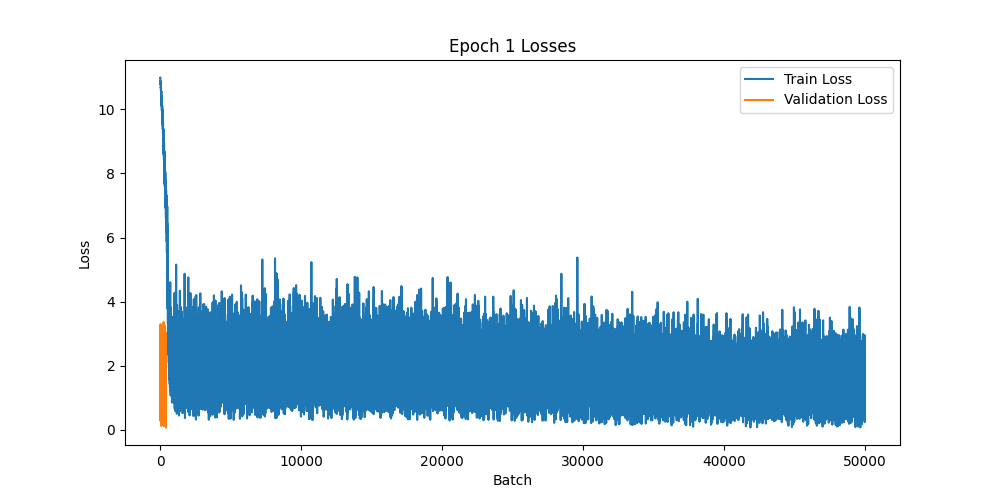

In [19]:
Image(filename="plots/epoch_1_losses.png", width=500, height=300)

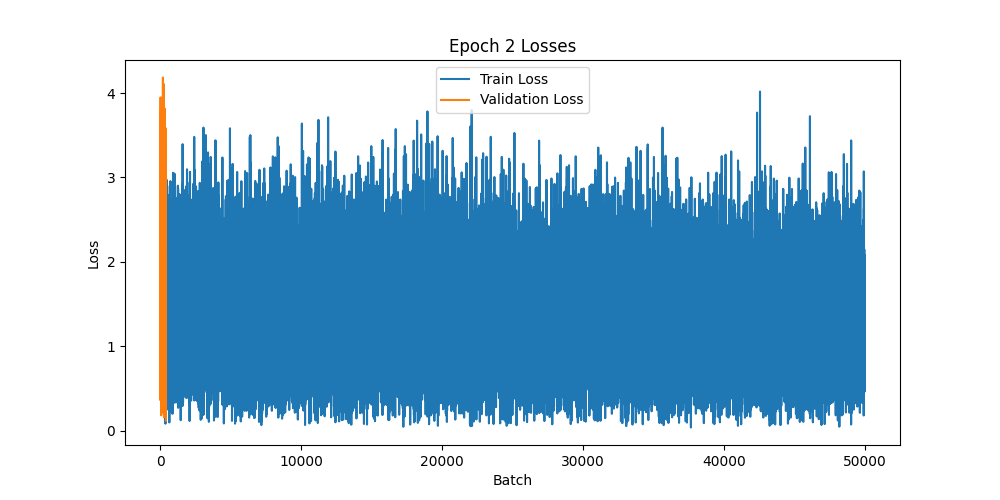

In [20]:
Image(filename="plots/epoch_2_losses.png", width=500, height=300)

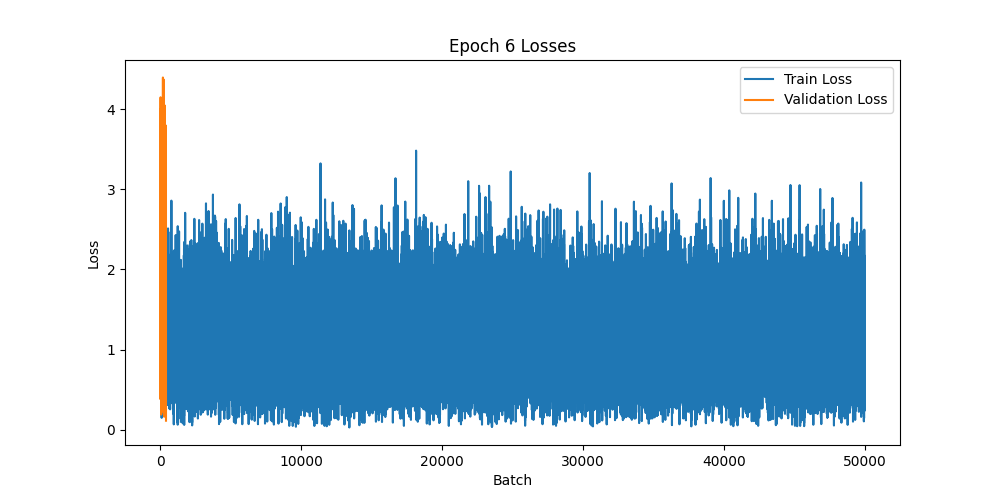

In [21]:
Image(filename="plots/epoch_6_losses.png", width=500, height=300)

In [26]:
from google.colab import files as colab_files
colab_files.download('best_peer_language_model.pth')
colab_files.download('final_peer_language_model.pth')
for root, _, files in os.walk('plots'):
    for filename in files:  # loop through files in the current directory
        colab_files.download(os.path.join(root, filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>